In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [2]:
N_ENSEMBLE=50

In [4]:
def truncated_mean_axis0(data, percentage=10):
    """
    Calculate truncated mean along axis 0
    
    Parameters:
    -----------
    data : 2D numpy array
        Input data array with shape (n_samples, n_features)
    percentage : float
        Percentage to trim from both ends (default: 10%)
        
    Returns:
    --------
    1D numpy array
        Truncated mean for each feature
    """
    n_samples = data.shape[0]
    n_features = data.shape[1]
    
    # Calculate number of elements to remove from each end
    k = int(n_samples * percentage / 100 / 2)
    
    # Initialize result array
    result = np.zeros(n_features)
    
    # For each feature (column), calculate truncated mean
    for i in range(n_features):
        column = np.sort(data[:, i])
        # Remove k smallest and k largest values and compute mean
        result[i] = np.mean(column[k:n_samples-k])
    
    return result

In [48]:
def plot_feature(feature, xlabel, title, unit):
    ## first get baseline rapgap and djangoh
    fig = plt.figure(figsize=(20, 5))  # Increased height to accommodate new plots
    outer_gs = gridspec.GridSpec(1, 3, figure=fig, hspace=0.3, wspace=0.2) # 2 rows, 3 cols, with padding

    alpha = 0.8
    label_size = 16
    E_Max = 5

    rapgap = np.load(f'../plots/Rapgap_H1_March_ModelLists_5lrscale_patience10_parallel_closure_{feature}_ens0_plot_vals.npy')
    djangoh = np.load(f'../plots/Djangoh_H1_March_ModelLists_5lrscale_patience10_parallel_closure_{feature}_ens0_plot_vals.npy')

    inner_gs = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=outer_gs[0, 0], height_ratios=[3, 1], hspace=0.05
    )
    ax1_top = fig.add_subplot(inner_gs[0])
    ax1_bottom = fig.add_subplot(inner_gs[1], sharex=ax1_top)
    r_scatter = ax1_top.scatter(
        rapgap[0], rapgap[1],
        marker='_', label='Rapgap',
        alpha=alpha, s=100, color='k'
    )
    print(f"rapgap[1]: {rapgap[1]}")
    d_scatter = ax1_top.fill_between(
        djangoh[0], djangoh[1],
        step='mid', color='gray',
        alpha=0.3, label='Djangoh'
    )

    ax1_top.set_title(f'{title}', fontsize=20)
    ax1_top.set_ylabel('Normalized Counts', fontsize=label_size)
    ax1_top.tick_params(axis='both', which='major', labelsize=12)
    # Remove x-axis tick marks and labels on the top subplot
    ax1_top.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax1_top.grid(True)

    # --- Bottom Subplot: Ratio Plot ---
    ax1_bottom.set_ylabel(r'Ratio', fontsize=label_size)
    ax1_bottom.set_xlabel(f'{xlabel} {unit}', fontsize=label_size)
    ax1_bottom.set_ylim(0.5, 1.5)
    ax1_bottom.tick_params(axis='both', which='major', labelsize=12)
    ax1_bottom.grid(True)

    # Group the ensemble models into chunks of 10
    chunk_size = 10
    num_chunks = (N_ENSEMBLE + chunk_size - 1) // chunk_size  # Ceiling division to handle non-divisible cases
    
    # Initialize arrays to store the chunk statistics
    chunk_means = []
    chunk_medians = []
    chunk_truncmeans = []
    chunk_file_paths = []  # Store file paths for each chunk for std_dev calculations
    
    # For storing x values
    x_values = None
    
    # Process each chunk
    for chunk_idx in range(num_chunks):
        start_idx = chunk_idx * chunk_size
        end_idx = min(start_idx + chunk_size, N_ENSEMBLE)
        
        # Arrays to collect data and file paths for this chunk
        chunk_y_vals = []
        chunk_files = []
        
        # Process each ensemble in this chunk
        for n in range(start_idx, end_idx):
            step_file = f'../plots/Rapgap_unfolded{n}_H1_March_ModelLists_5lrscale_patience10_parallel_closure_{feature}_ens{n}_plot_vals.npy'
            
            if not os.path.exists(step_file):
                print(f"Skipping missing file: {step_file}")
                continue
                
            # Add file path to the chunk files
            chunk_files.append(step_file)
            
            step_data = np.load(step_file)
            
            # Store x values once, assuming they're the same for all files
            if x_values is None:
                x_values = step_data[0]
                
            chunk_y_vals.append(step_data[1])
        
        # Skip empty chunks
        if not chunk_y_vals or len(chunk_files) < 2:  # Need at least 2 files for std dev calculation
            print(f"Skipping empty or single-file chunk {chunk_idx+1}")
            continue
            
        # Convert to numpy array for calculations
        chunk_y_vals_arr = np.vstack(chunk_y_vals)
        
        # Calculate statistics for this chunk
        chunk_mean = np.mean(chunk_y_vals_arr, axis=0)
        chunk_median = np.median(chunk_y_vals_arr, axis=0)
        chunk_truncmean = truncated_mean_axis0(chunk_y_vals_arr, percentage=10)
        
        # Store chunk statistics
        chunk_means.append(chunk_mean)
        chunk_medians.append(chunk_median)
        chunk_truncmeans.append(chunk_truncmean)
        chunk_file_paths.append(chunk_files)  # Store file paths for std_dev calculations
        
        # print(f"Chunk {chunk_idx+1} statistics calculated")
    
    # Calculate standard deviations for each chunk
    chunk_std_devs = []
    chunk_ratio_std_devs = []  # To store ratio std devs
    chunk_std_dev_ratios = []  # To store ratios between std devs
    
    # Arrays to store per-x-value statistics for the final plots
    all_x_values = None
    all_std_devs_per_x = []
    all_mse_per_x = []
    
    # Arrays to store std_devs for each statistical method
    all_mean_std_devs_per_x = []
    all_median_std_devs_per_x = []
    all_truncmean_std_devs_per_x = []
    
    # Arrays to store MSE for each statistical method
    all_mean_mse_per_x = []
    all_median_mse_per_x = []
    all_truncmean_mse_per_x = []
    
    for chunk_idx, chunk_files in enumerate(chunk_file_paths):
        if len(chunk_files) >= 2:  # Need at least 2 files for std dev calculation
            # Use the provided get_stdv_from_files function
            x_vals, std_devs, ratio_std_devs, means = get_stdv_from_files(chunk_files, truth=None)
            
            # Store all x values (only need to do this once)
            if all_x_values is None:
                all_x_values = x_vals
            
            # Store std_devs for later plotting
            all_std_devs_per_x.append(std_devs)
            
            # Calculate MSE compared to djangoh truth
            _, mse_values, _, _ = get_stdv_from_files(chunk_files, truth=djangoh)
            all_mse_per_x.append(mse_values)
            
            # Store average std_dev and ratio_std_dev for this chunk
            avg_std_dev = np.mean(std_devs)
            avg_ratio_std_dev = np.mean(ratio_std_devs)
            
            chunk_std_devs.append(avg_std_dev)
            chunk_ratio_std_devs.append(avg_ratio_std_dev)
            
            # Calculate ratio of std_dev to ratio_std_dev if needed
            if avg_ratio_std_dev > 0:
                std_dev_ratio = avg_std_dev / avg_ratio_std_dev
                chunk_std_dev_ratios.append(std_dev_ratio)
            
            # print(f"Chunk {chunk_idx+1} avg std_dev: {avg_std_dev:.4f}")
            # print(f"Chunk {chunk_idx+1} avg ratio_std_dev: {avg_ratio_std_dev:.4f}")
            # print(f"Chunk {chunk_idx+1} std_dev ratio: {std_dev_ratio:.4f}")
    
    # Calculate the average of all chunk statistics
    if chunk_means:
        final_mean = np.mean(chunk_means, axis=0)
        final_median = np.mean(chunk_medians, axis=0)
        final_truncmean = np.mean(chunk_truncmeans, axis=0)
        
        # Calculate average of standard deviations
        final_std_dev = np.mean(chunk_std_devs) if chunk_std_devs else 0
        final_std_dev_ratio = np.mean(chunk_std_dev_ratios) if chunk_std_dev_ratios else 0
        
        # print(f"Final mean (avg of chunk means): {final_mean}")
        # print(f"Final median (avg of chunk medians): {final_median}")
        # print(f"Final truncmean (avg of chunk truncmeans): {final_truncmean}")
        # print(f"Final std_dev (avg of chunk std_devs): {final_std_dev}")
        # print(f"Final std_dev ratio (avg of chunk ratios): {final_std_dev_ratio}")
        
        # Plot the final statistics
        ax1_top.scatter(x_values, final_mean, marker='o', label="Mean", color='blue', facecolors='none')    
        ax1_top.scatter(x_values, final_median, marker='*', label="Median", color='green', facecolors='none')    
        ax1_top.scatter(x_values, final_truncmean, marker='v', label="Truncated Mean", color='red', facecolors='none')    
        
        ax1_top.set_ylim(0, 1.5*np.max(final_truncmean))
        
        # Plot ratios
        ax1_bottom.scatter(
            rapgap[0], rapgap[1]/djangoh[1],
            marker='_', alpha=alpha, color='k'
        )
        
        ax1_bottom.scatter(
            x_values, final_mean/djangoh[1],
            marker='o', alpha=alpha, color='blue', facecolors='none'
        )
        
        ax1_bottom.scatter(
            x_values, final_median/djangoh[1],
            marker='*', alpha=alpha, color='green', facecolors='none'
        )
        
        ax1_bottom.scatter(
            x_values, final_truncmean/djangoh[1],
            marker='v', alpha=alpha, color='red', facecolors='none'
        )
    else:
        print("No valid chunks found")
    
    ax1_bottom.axhline(y=1.0, color='gray', linestyle='--', alpha=0.7)  # Reference line at ratio=1
    
    ax1_top.legend(fontsize=12, loc='upper right', ncol=2, columnspacing=1.5, handletextpad=0.5)
    
    # For compatibility with existing code - calculate overall statistics
    if chunk_file_paths:
        # Flatten all file paths into a single list
        all_files = [file for sublist in chunk_file_paths for file in sublist]
        
        if len(all_files) >= 2:
            # Calculate overall statistics using all files together
            overall_x, overall_std_devs, overall_ratio_std_devs, overall_means = get_stdv_from_files(all_files, truth=None)
            
            # Calculate MSE using djangoh as truth
            _, overall_mse_values, _, _ = get_stdv_from_files(all_files, truth=djangoh)
            
            # Calculate statistics for each method separately (mean, median, truncmean)
            # Create arrays to compare with djangoh
            mean_comparison = [np.load(file)[1] for file in all_files]
            mean_comparison = np.vstack(mean_comparison)
            
            # Calculate median and truncated mean arrays
            median_values = np.median(mean_comparison, axis=0)
            truncmean_values = truncated_mean_axis0(mean_comparison, percentage=10)
            
            # Calculate stats for each method
            _, mean_std_devs, _, _ = get_stdv_from_files(all_files, truth=None)
            
            # For median stats, create synthetic files with median values
            median_data = [djangoh[0], median_values, djangoh[0]/median_values]
            median_file = '../plots/temp_median_data.npy'
            np.save(median_file, median_data)
            
            # For truncmean stats, create synthetic files with truncmean values
            truncmean_data = [djangoh[0], truncmean_values, djangoh[0]/truncmean_values]
            truncmean_file = '../plots/temp_truncmean_data.npy'
            np.save(truncmean_file, truncmean_data)
            
            # Calculate MSE for each method
            _, mean_mse_values, _, _ = get_stdv_from_files(all_files, truth=djangoh)
            _, median_mse_values, _, _ = get_stdv_from_files([median_file], truth=djangoh)
            _, truncmean_mse_values, _, _ = get_stdv_from_files([truncmean_file], truth=djangoh)
            
            overall_avg_std_dev = np.mean(overall_std_devs)
            overall_avg_ratio_std_dev = np.mean(overall_ratio_std_devs)
            
            # print(f"Overall average std_dev: {overall_avg_std_dev:.4f}")
            # print(f"Overall average ratio_std_dev: {overall_avg_ratio_std_dev:.4f}")
            
            # Create visualizations for std_devs and ratio_std_devs per chunk
            if len(chunk_std_devs) > 1:
                
                
                # If we calculated std_dev ratios, print their average
                if chunk_std_dev_ratios:
                    final_std_dev_ratio = np.mean(chunk_std_dev_ratios)
                    # print(f"Average of std_dev ratios: {final_std_dev_ratio:.4f}")
                
                # NEW PLOT: Standard Deviation vs X Values
                # Calculate average std_dev for each x value across all chunks
                if all_std_devs_per_x:
                    avg_std_devs_per_x = np.mean(all_std_devs_per_x, axis=0)
                    
                    
                    ax4 = fig.add_subplot(outer_gs[1])
                    ax4.plot(all_x_values, overall_std_devs, 'o-', color='blue', linewidth=2, label='Mean', markerfacecolor='none')
                    
                    # Calculate std_dev for median method (if available)
                    if median_values is not None:
                        # Calculate deviation of individual samples from median
                        median_deviations = np.array([abs(mean_comparison[i] - median_values) for i in range(len(mean_comparison))])
                        median_std_devs = np.mean(median_deviations, axis=0) / median_values
                        ax4.plot(all_x_values, median_std_devs, '*-', color='green', linewidth=2, label='Median', markerfacecolor='none')
                    
                    # Calculate std_dev for truncated mean method (if available)
                    if truncmean_values is not None:
                        # Calculate deviation of individual samples from truncated mean
                        truncmean_deviations = np.array([abs(mean_comparison[i] - truncmean_values) for i in range(len(mean_comparison))])
                        truncmean_std_devs = np.mean(truncmean_deviations, axis=0) / truncmean_values
                        ax4.plot(all_x_values, truncmean_std_devs, 'v-', color='red', linewidth=2, label='Truncated Mean', markerfacecolor='none')
                    
                    ax4.set_xlabel(f'{xlabel} {unit}', fontsize=label_size)
                    ax4.set_ylabel('Standard Deviation / Mean', fontsize=label_size)
                    ax4.set_title('Standard Deviation vs X Values', fontsize=20)
                    ax4.grid(True, alpha=0.3)
                    ax4.legend()
                
                # NEW PLOT: MSE vs X Values
                # Calculate average MSE for each x value across all chunks
                if all_mse_per_x:
                    avg_mse_per_x = np.mean(all_mse_per_x, axis=0)
                    
                    
                    ax5 = fig.add_subplot(outer_gs[2])
                    ax5.plot(all_x_values, overall_mse_values, 'o-', color='blue', linewidth=2, label='Mean', markerfacecolor='none')
                    
                    # Add median and truncated mean MSE curves
                    if median_mse_values is not None:
                        ax5.plot(all_x_values, median_mse_values, '*-', color='green', linewidth=2, label='Median', markerfacecolor='none')
                    
                    if truncmean_mse_values is not None:
                        ax5.plot(all_x_values, truncmean_mse_values, 'v-', color='red', linewidth=2, label='Truncated Mean', markerfacecolor='none')
                    
                    ax5.set_xlabel(f'{xlabel} {unit}', fontsize=label_size)
                    ax5.set_ylabel('MSE / Mean (vs Djangoh)', fontsize=label_size)
                    ax5.set_title('MSE vs X Values', fontsize=20)
                    ax5.grid(True, alpha=0.3)
                    
                    # Add reference line for average MSE
                    avg_mse = np.mean(overall_mse_values)
                    
                    ax5.legend()
               
    
    plt.tight_layout()
    # plt.savefig(f'../plots/extended_{feature}_plot.png', dpi=300, bbox_inches='tight')
    # plt.close()

rapgap[1]: [0.10708266 0.02916028 0.00532018 0.00088265 0.00012603]
rapgap[1]: [0.23928345 0.57189496 0.66485931 0.339618   0.13068226 0.05366201]


/tmp/ipykernel_1291125/4010664139.py:318: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


rapgap[1]: [4.46636612 1.20221162 0.58427083 0.33521577 0.20281139 0.12889996
 0.0802243 ]
rapgap[1]: [4.2626574  5.2817564  5.21333448 3.52708764 1.67628612 0.65036118
 0.14344823]
rapgap[1]: [0.17293483 0.35060431 0.47179123 0.36781683 0.13425838 0.00259439]
rapgap[1]: [0.06179632 0.21360616 0.47042482 0.50624741 0.23827441 0.00965094]
rapgap[1]: [0.00425513 0.03394159 0.21861772 0.65318656 0.52536438 0.06463466]
rapgap[1]: [0.         0.83108726 3.62582671 1.25599434 0.24286307 0.04422847]


/tmp/ipykernel_1291125/3290034408.py:22: RuntimeWarning: invalid value encountered in scalar divide
  std_devs = [np.std(y_values)/np.mean(y_values) for y_values in y_values_per_x_index.values()]
/tmp/ipykernel_1291125/4010664139.py:233: RuntimeWarning: divide by zero encountered in divide
  median_data = [djangoh[0], median_values, djangoh[0]/median_values]
/tmp/ipykernel_1291125/4010664139.py:238: RuntimeWarning: divide by zero encountered in divide
  truncmean_data = [djangoh[0], truncmean_values, djangoh[0]/truncmean_values]
/tmp/ipykernel_1291125/4010664139.py:275: RuntimeWarning: invalid value encountered in divide
  median_std_devs = np.mean(median_deviations, axis=0) / median_values
/tmp/ipykernel_1291125/4010664139.py:282: RuntimeWarning: invalid value encountered in divide
  truncmean_std_devs = np.mean(truncmean_deviations, axis=0) / truncmean_values


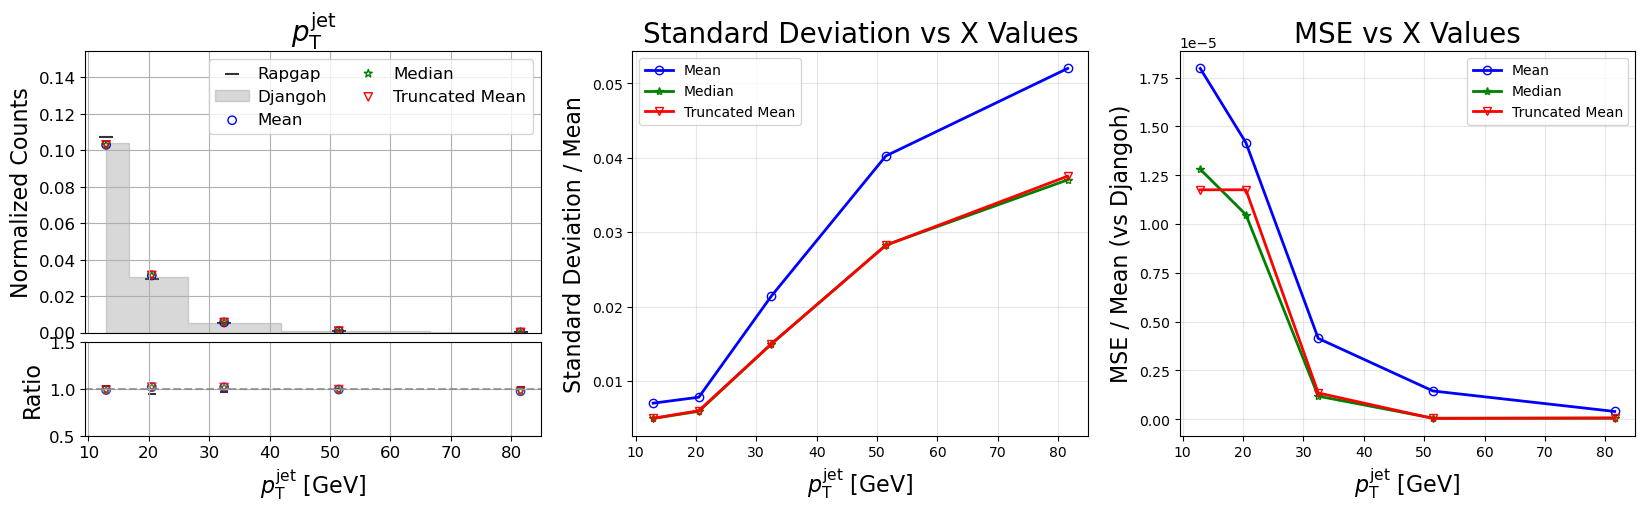

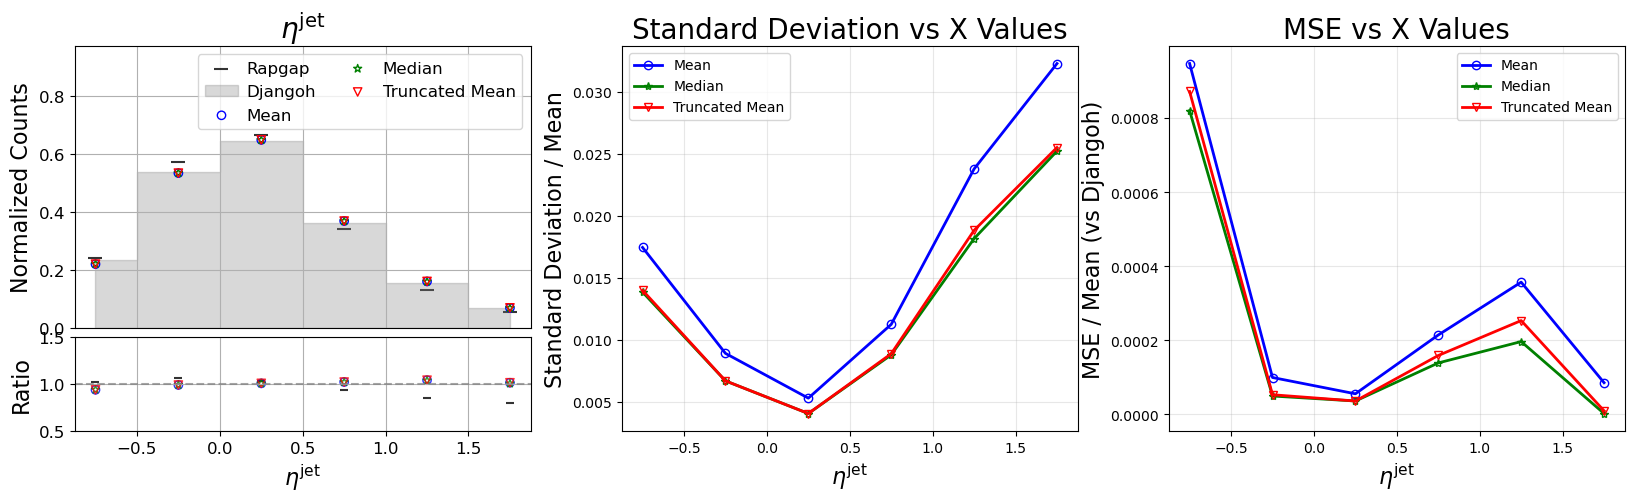

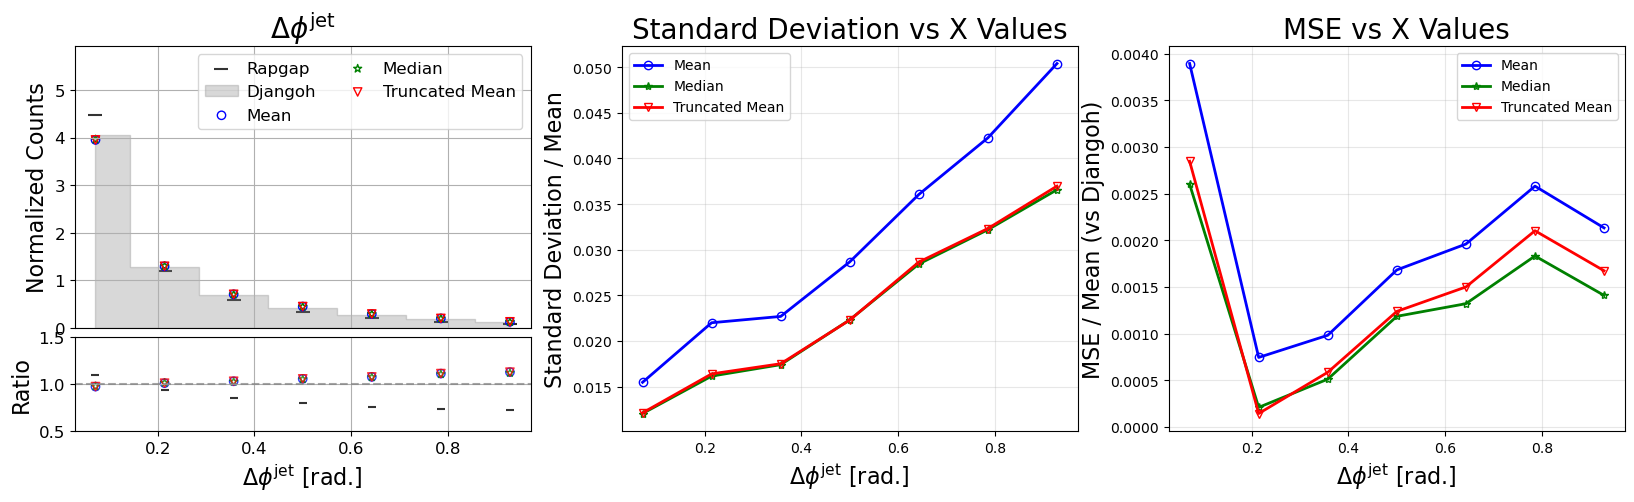

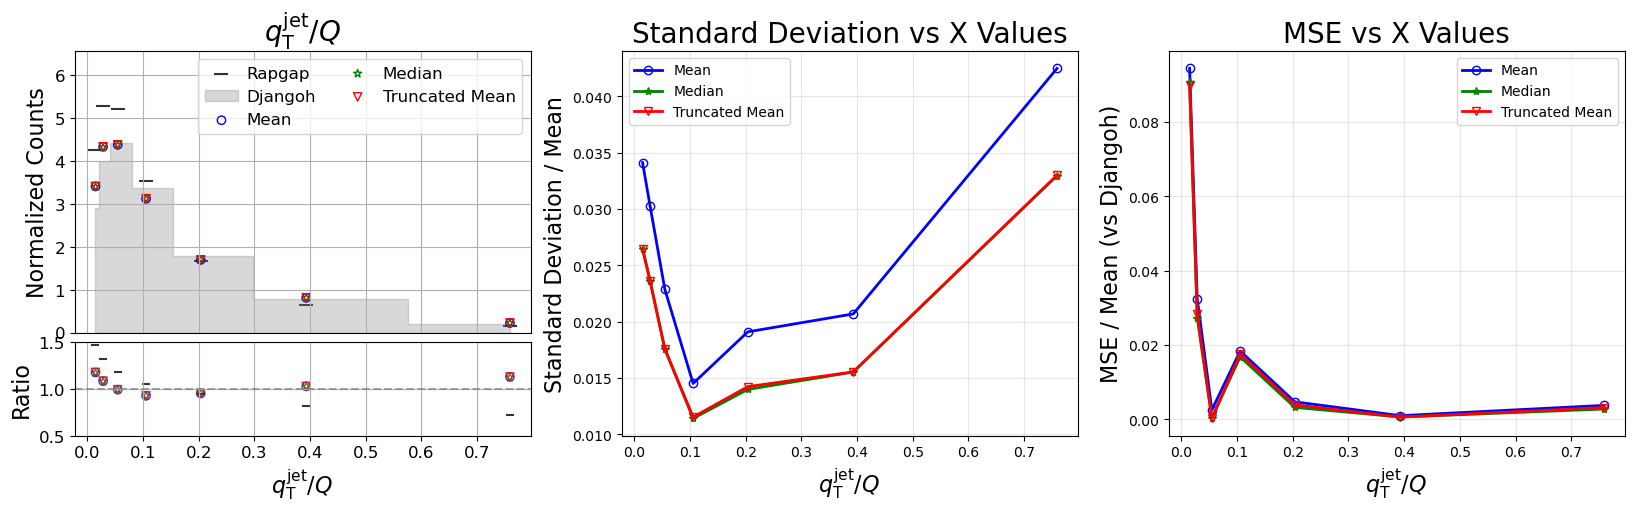

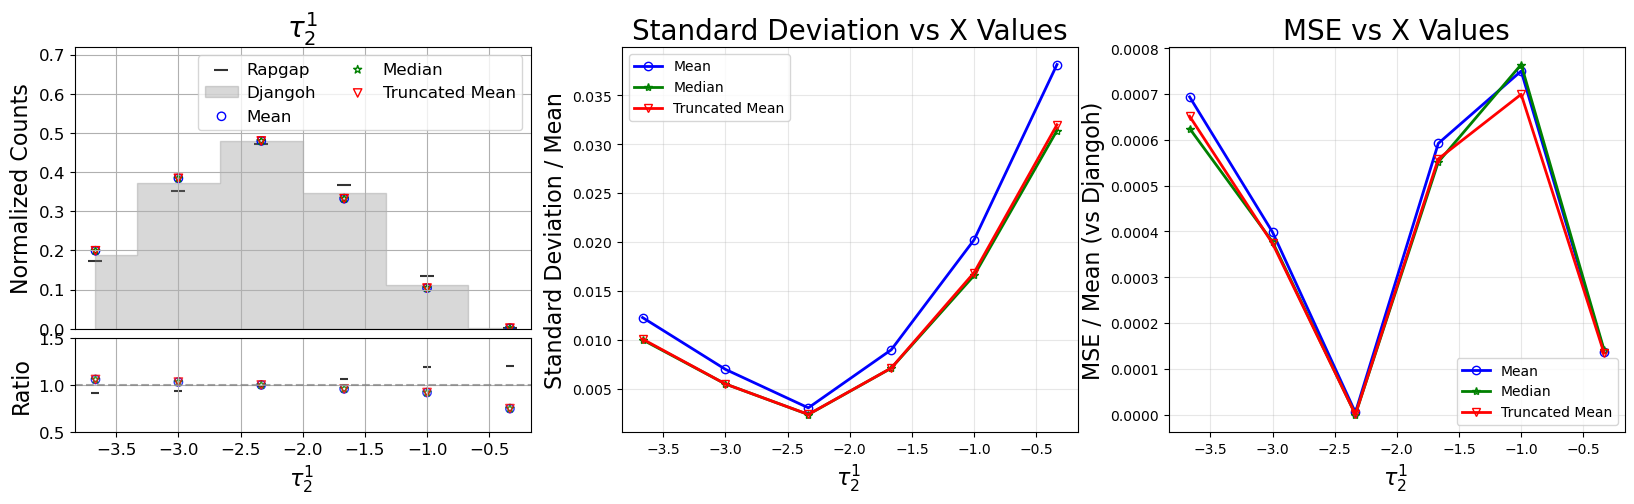

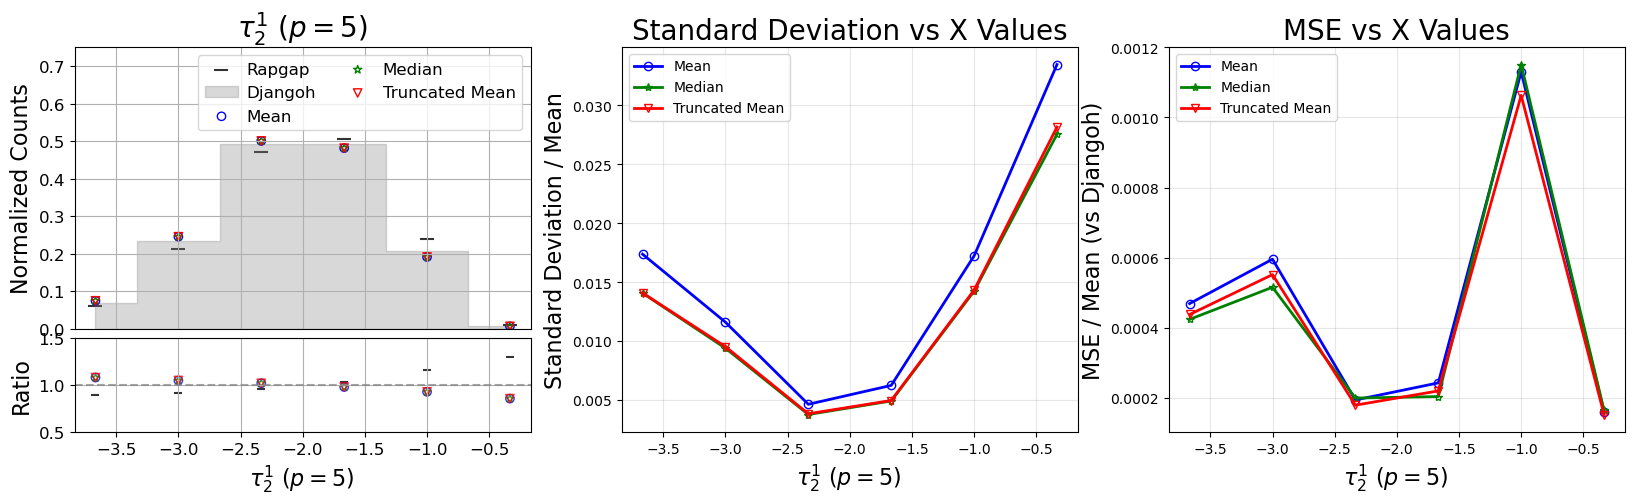

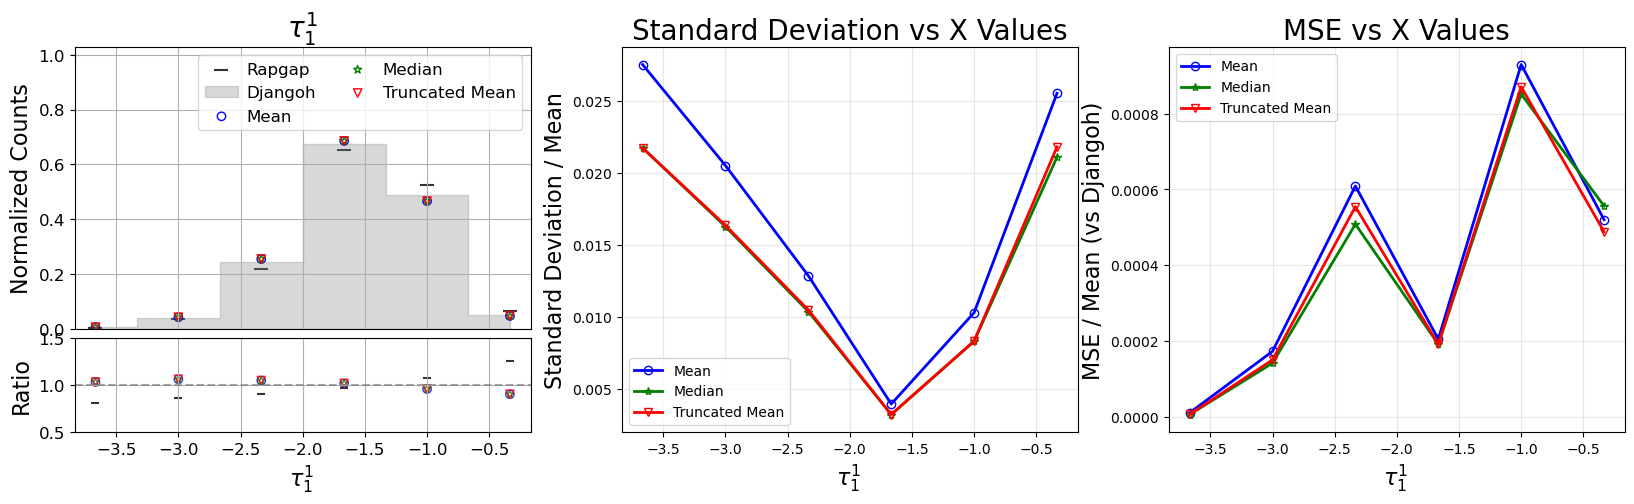

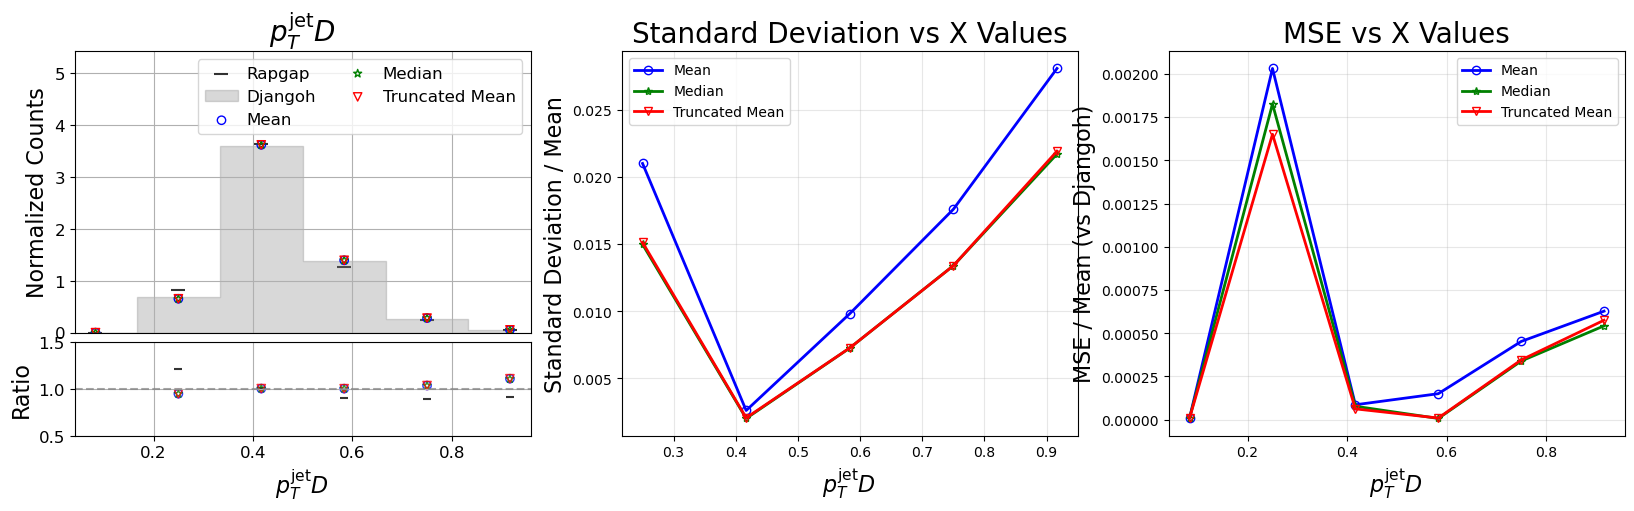

In [49]:
jet_features = ['jet_pT', 'jet_eta', 'jet_phi', 'jet_qT', 'jet_tau12', 'jet_tau11p5', 'jet_tau11', 'jet_ptD']
jet_labels = [r'$p_\mathrm{T}^\mathrm{jet}$',r'$\eta^\mathrm{jet}$',
              r'$\Delta\phi^\mathrm{jet}$',r'$q_\mathrm{T}^\mathrm{jet}/Q$', 
              r'$\tau^1_2$', r'$\tau^1_2\ (p=5)$', r'$\tau^1_1$', '$p^\mathrm{jet}_{T}D$']
units = ['[GeV]','','[rad.]','','','','','']
for jet_feature, jet_label, unit in zip(jet_features, jet_labels, units):
    plot_feature(jet_feature, jet_label, jet_label, unit)

rapgap[1]: [1.05649958 1.07568825 1.03929168 0.97177851 0.9071045  0.83495844
 0.77038652 0.71249895 0.64697316 0.59786266 0.54318169 0.49193032
 0.44675405 0.40469099 0.36485279 0.32800326 0.30137665 0.2635128
 0.24673188 0.2213129  0.20354155 0.18522864 0.17026063 0.15748779
 0.1450726  0.12913587 0.12178146 0.11136018 0.10004548 0.09183964
 0.08307053 0.07361506 0.06618391 0.05891203 0.05408729 0.04869782
 0.04441752 0.04001124 0.0333287  0.03207763 0.02718627 0.02466819
 0.02220803 0.02235139 0.02069342 0.0186054  0.01812611 0.01683015
 0.01518377]
Chunk 1 statistics calculated
Chunk 2 statistics calculated
Chunk 3 statistics calculated
Chunk 4 statistics calculated
Chunk 5 statistics calculated
Chunk 1 avg std_dev: 0.0123
Chunk 1 avg ratio_std_dev: 0.0118
Chunk 1 std_dev ratio: 1.0360
Chunk 2 avg std_dev: 0.0152
Chunk 2 avg ratio_std_dev: 0.0148
Chunk 2 std_dev ratio: 1.0295
Chunk 3 avg std_dev: 0.0133
Chunk 3 avg ratio_std_dev: 0.0130
Chunk 3 std_dev ratio: 1.0229
Chunk 4 avg std

/tmp/ipykernel_1291125/326430849.py:318: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Chunk 2 statistics calculated
Chunk 3 statistics calculated
Chunk 4 statistics calculated
Chunk 5 statistics calculated
Chunk 1 avg std_dev: 0.0066
Chunk 1 avg ratio_std_dev: 0.0066
Chunk 1 std_dev ratio: 1.0082
Chunk 2 avg std_dev: 0.0073
Chunk 2 avg ratio_std_dev: 0.0073
Chunk 2 std_dev ratio: 1.0074
Chunk 3 avg std_dev: 0.0117
Chunk 3 avg ratio_std_dev: 0.0116
Chunk 3 std_dev ratio: 1.0070
Chunk 4 avg std_dev: 0.0085
Chunk 4 avg ratio_std_dev: 0.0084
Chunk 4 std_dev ratio: 1.0061
Chunk 5 avg std_dev: 0.0100
Chunk 5 avg ratio_std_dev: 0.0099
Chunk 5 std_dev ratio: 1.0104
Final mean (avg of chunk means): [3.93858671 3.81501849 3.79511565 3.66101263 3.49712197 3.47167654
 3.2799701  3.25171875 3.13987321 3.04716233 2.96764313 2.89617305
 2.75489464 2.74036897 2.62933343 2.5613057  2.47557264 2.40413096
 2.32930413 2.22374366 2.17277763 2.12951641 2.04198616 1.98457936
 1.93381605 1.85628003 1.83938089 1.75672223 1.75432853 1.65946613
 1.57998162 1.52560589 1.49725413 1.46875001 1.39396

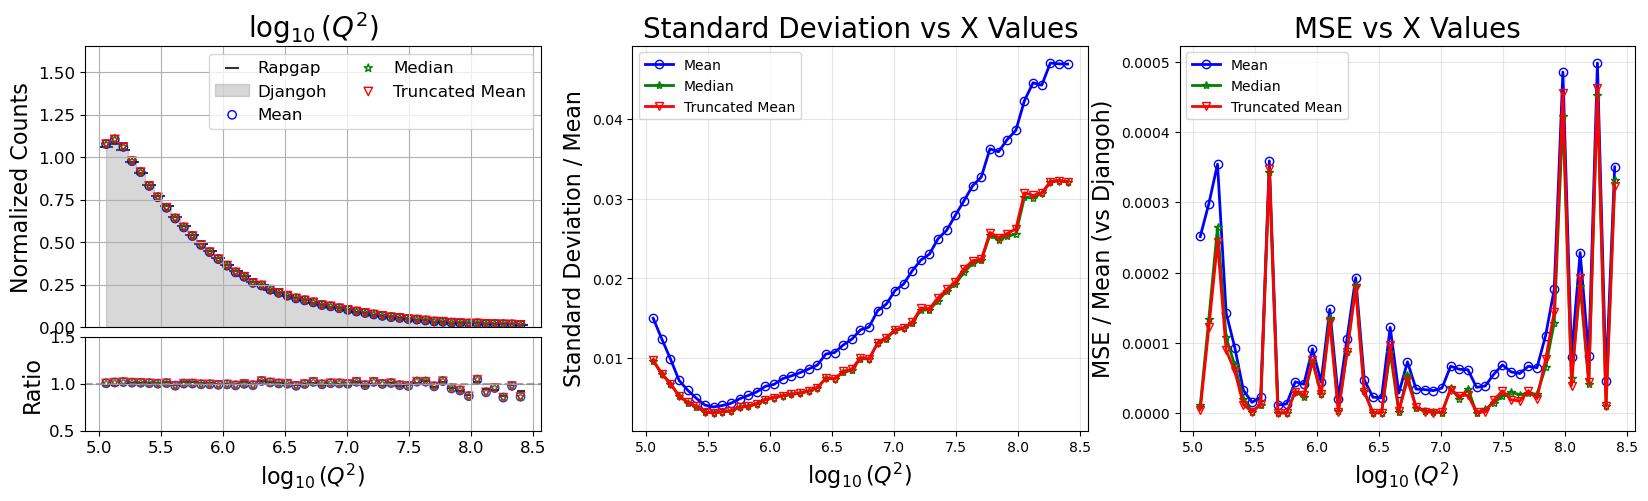

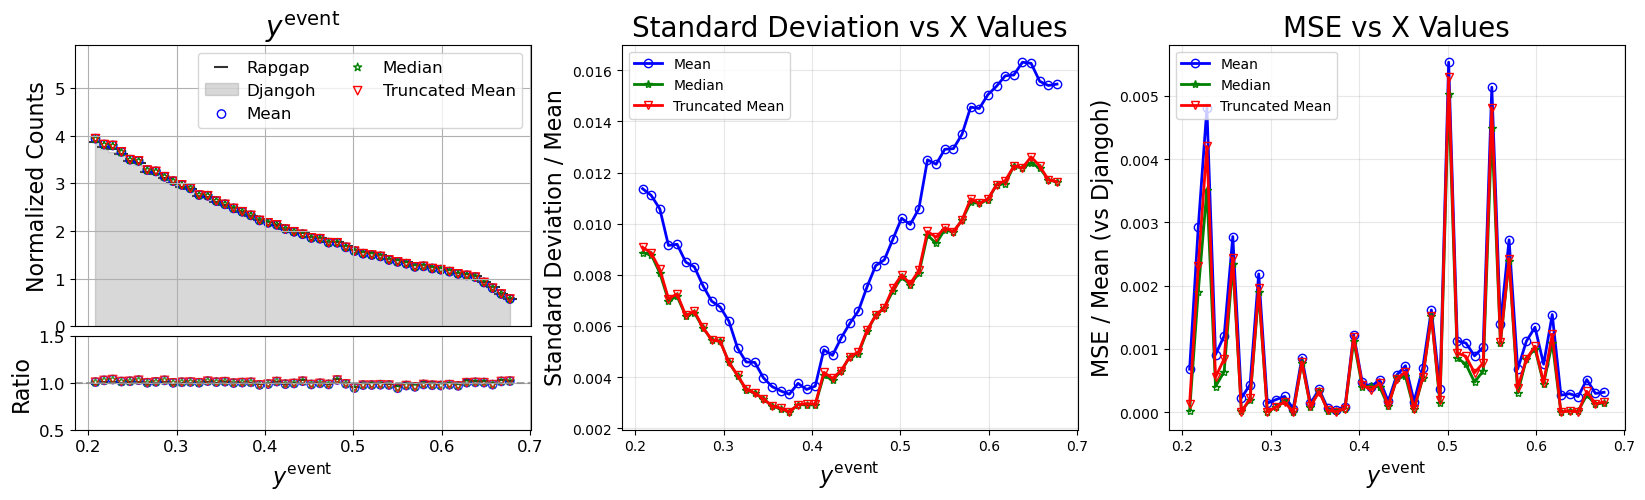

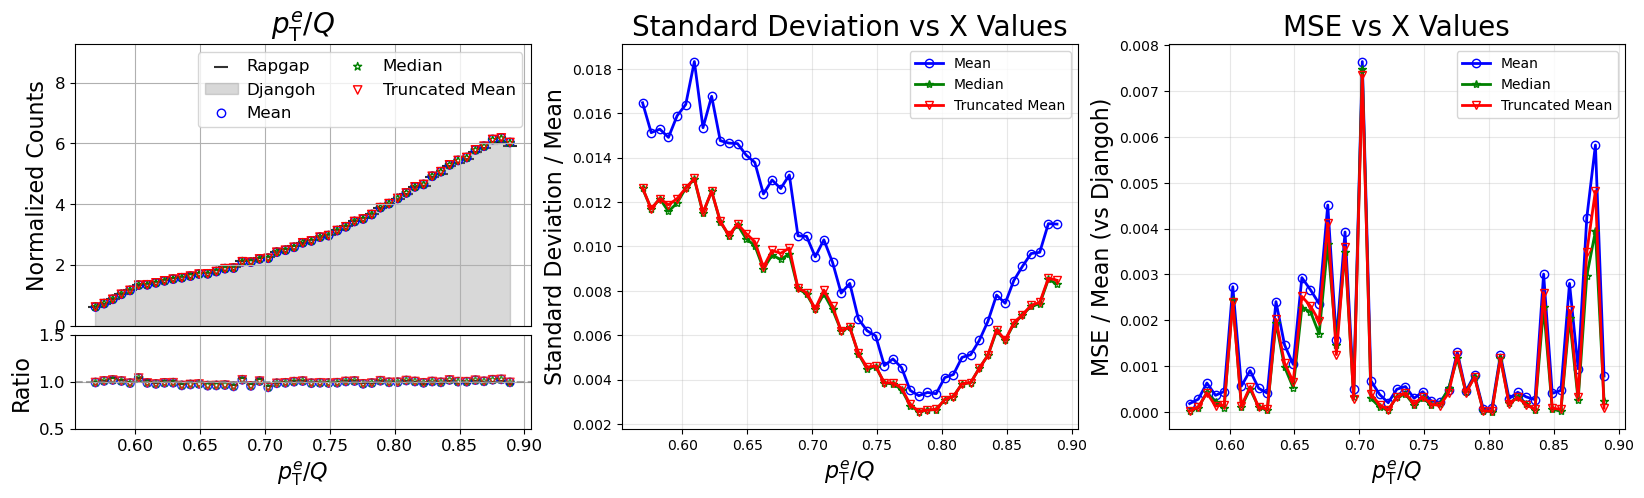

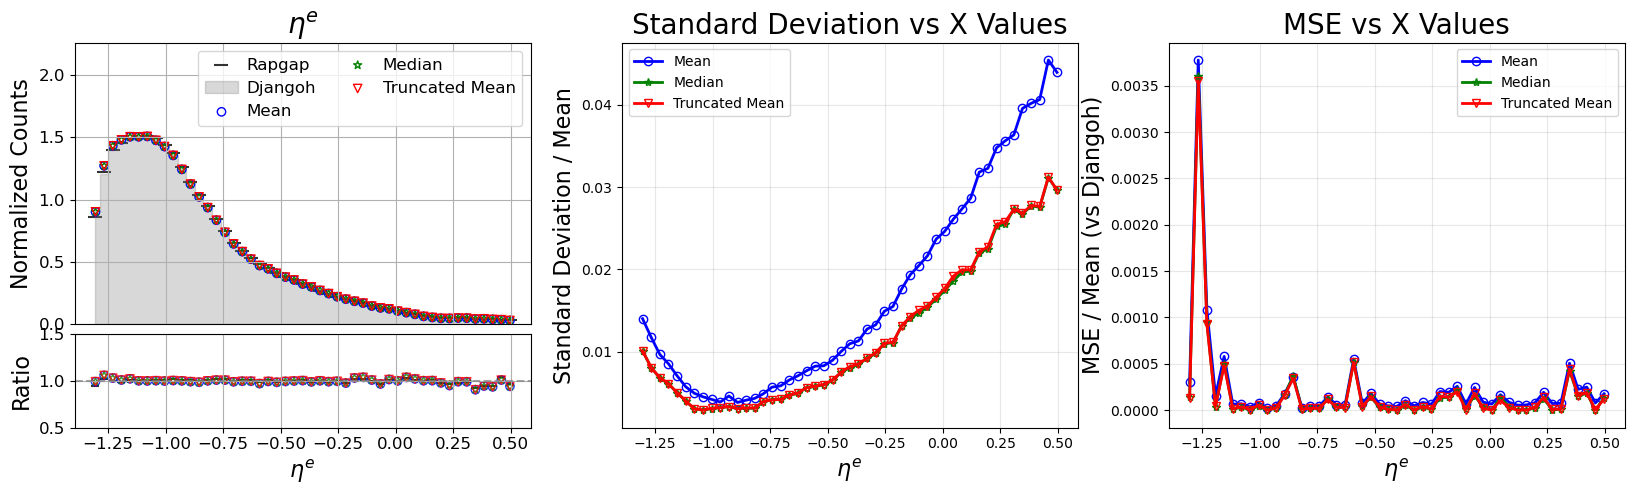

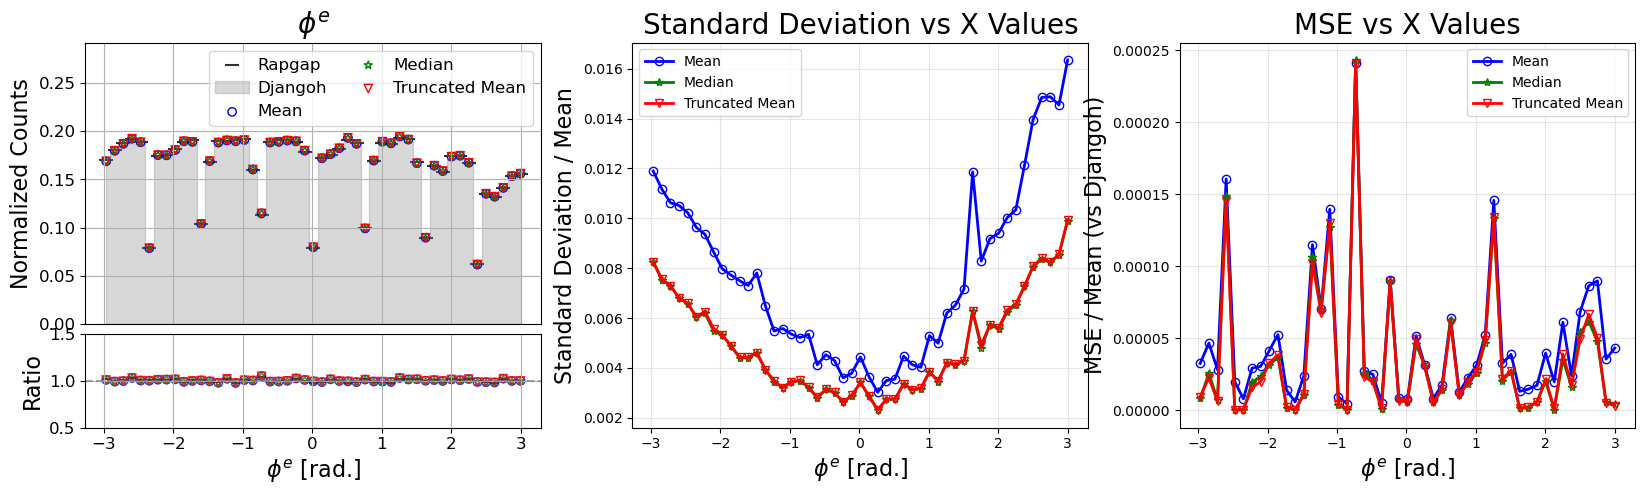

In [41]:
event_labels = [r'$\log_{10}(Q^2)$',r'$y^\mathrm{event}$',r'$p_\mathrm{T}^e/Q$',r'$\eta^e$',r'$\phi^e$']
event_features = [f"event{e}" for e in range(len(event_labels))]
units = ["", "", "", "", "[rad.]"]

for event_feature, event_label, unit in zip(event_features, event_labels, units):
    plot_feature( event_feature,event_label, event_label, unit)
    print()

rapgap[1]: [0.04776768 0.06509587 0.08316435 0.10108674 0.11798824 0.13604581
 0.15377484 0.17156685 0.19021636 0.20862245 0.22853393 0.24857206
 0.2683726  0.28707174 0.30518498 0.32345136 0.33987523 0.35417167
 0.36584962 0.37597486 0.37766973 0.37233104 0.35820817 0.33547744
 0.315225   0.29840982 0.28399125 0.27345682 0.26458114 0.2551117
 0.24853721 0.24361282 0.23737368 0.23152489 0.22733327 0.22326103
 0.21788189 0.21291431 0.2092434  0.20349985 0.19760157 0.19145669
 0.18377637 0.17598531 0.16596924 0.15435726 0.14049435 0.12238171
 0.10006487]
Chunk 1 statistics calculated
Chunk 2 statistics calculated
Chunk 3 statistics calculated
Chunk 4 statistics calculated
Chunk 5 statistics calculated
Chunk 1 avg std_dev: 0.0053
Chunk 1 avg ratio_std_dev: 0.0054
Chunk 1 std_dev ratio: 0.9949
Chunk 2 avg std_dev: 0.0090
Chunk 2 avg ratio_std_dev: 0.0090
Chunk 2 std_dev ratio: 0.9976
Chunk 3 avg std_dev: 0.0077
Chunk 3 avg ratio_std_dev: 0.0077
Chunk 3 std_dev ratio: 1.0063
Chunk 4 avg std

/tmp/ipykernel_1291125/326430849.py:318: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Chunk 2 statistics calculated
Chunk 3 statistics calculated
Chunk 4 statistics calculated
Chunk 5 statistics calculated
Chunk 1 avg std_dev: 0.0045
Chunk 1 avg ratio_std_dev: 0.0046
Chunk 1 std_dev ratio: 0.9840
Chunk 2 avg std_dev: 0.0077
Chunk 2 avg ratio_std_dev: 0.0079
Chunk 2 std_dev ratio: 0.9822
Chunk 3 avg std_dev: 0.0079
Chunk 3 avg ratio_std_dev: 0.0081
Chunk 3 std_dev ratio: 0.9830
Chunk 4 avg std_dev: 0.0075
Chunk 4 avg ratio_std_dev: 0.0077
Chunk 4 std_dev ratio: 0.9822
Chunk 5 avg std_dev: 0.0068
Chunk 5 avg ratio_std_dev: 0.0069
Chunk 5 std_dev ratio: 0.9815
Final mean (avg of chunk means): [0.06934348 0.07022748 0.07174128 0.07354441 0.07610722 0.07835901
 0.0815843  0.08470814 0.08859293 0.09386281 0.09912878 0.10538087
 0.11316855 0.12195397 0.13326402 0.14571351 0.16174989 0.18070468
 0.20445269 0.23468614 0.27337313 0.32641049 0.39753128 0.50668725
 0.60228426 0.50849222 0.40071851 0.32745779 0.27309889 0.23446647
 0.2032391  0.18020437 0.16152496 0.14573018 0.13224

/tmp/ipykernel_1291125/3290034408.py:22: RuntimeWarning: invalid value encountered in scalar divide
  std_devs = [np.std(y_values)/np.mean(y_values) for y_values in y_values_per_x_index.values()]
/tmp/ipykernel_1291125/3290034408.py:26: RuntimeWarning: invalid value encountered in scalar divide
  std_devs = [np.mean([(y - truth[1][i]) ** 2 for y in y_values])/np.mean(truth[1][i]) for i, y_values in y_values_per_x_index.items()]
/tmp/ipykernel_1291125/326430849.py:183: RuntimeWarning: invalid value encountered in divide
  rapgap[0], rapgap[1]/djangoh[1],
/tmp/ipykernel_1291125/326430849.py:188: RuntimeWarning: invalid value encountered in divide
  x_values, final_mean/djangoh[1],
/tmp/ipykernel_1291125/326430849.py:193: RuntimeWarning: invalid value encountered in divide
  x_values, final_median/djangoh[1],
/tmp/ipykernel_1291125/326430849.py:198: RuntimeWarning: invalid value encountered in divide
  x_values, final_truncmean/djangoh[1],
/tmp/ipykernel_1291125/326430849.py:233: RuntimeW

Chunk 3 avg std_dev: nan
Chunk 3 avg ratio_std_dev: 0.0001
Chunk 3 std_dev ratio: nan
Chunk 4 avg std_dev: nan
Chunk 4 avg ratio_std_dev: 0.0002
Chunk 4 std_dev ratio: nan
Chunk 5 avg std_dev: nan
Chunk 5 avg ratio_std_dev: 0.0002
Chunk 5 std_dev ratio: nan
Final mean (avg of chunk means): [ 2.2534651  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
 46.7465349]
Final median (avg of chunk medians): [ 2.25147078  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         

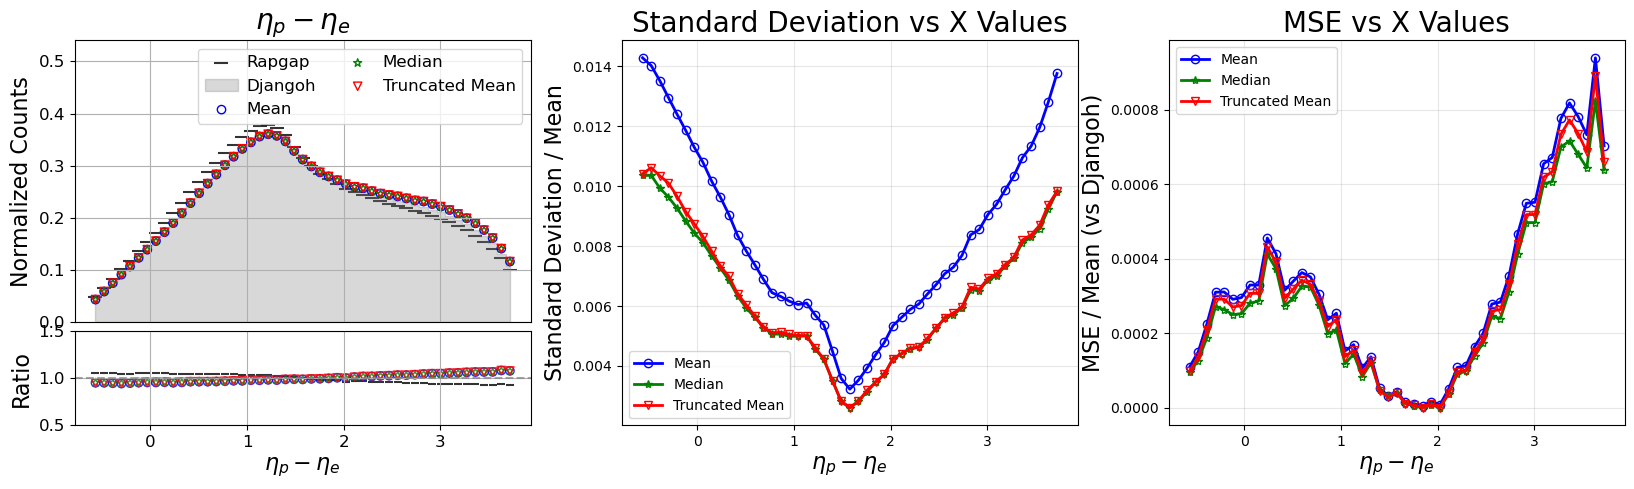

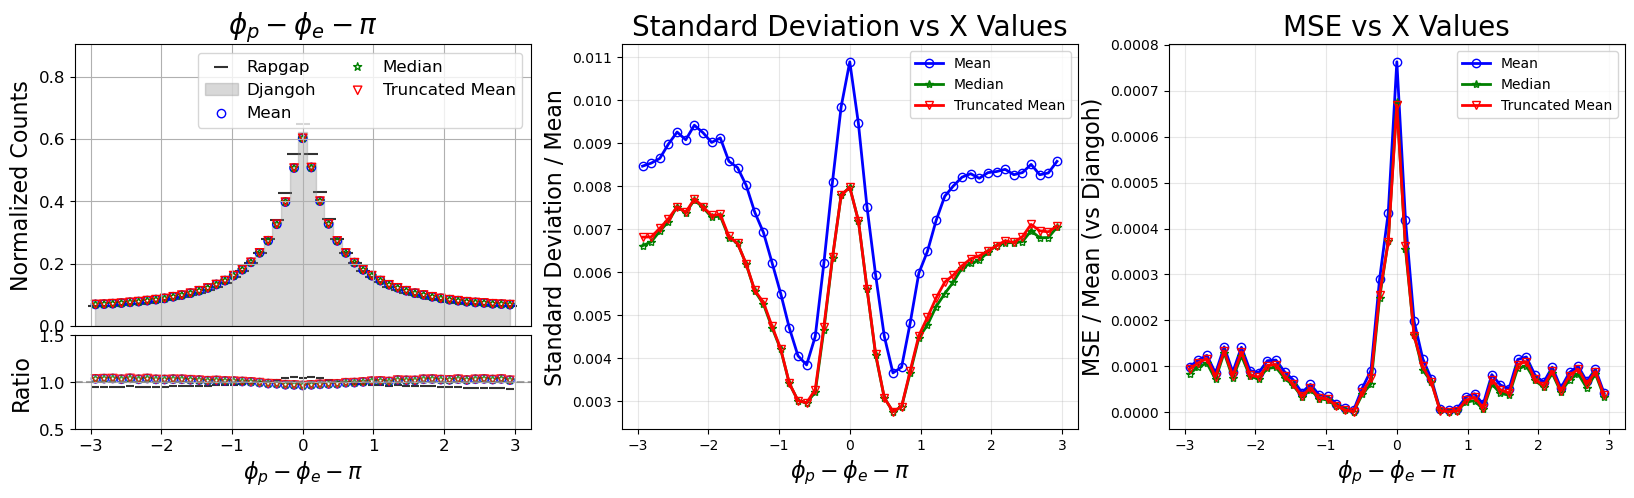

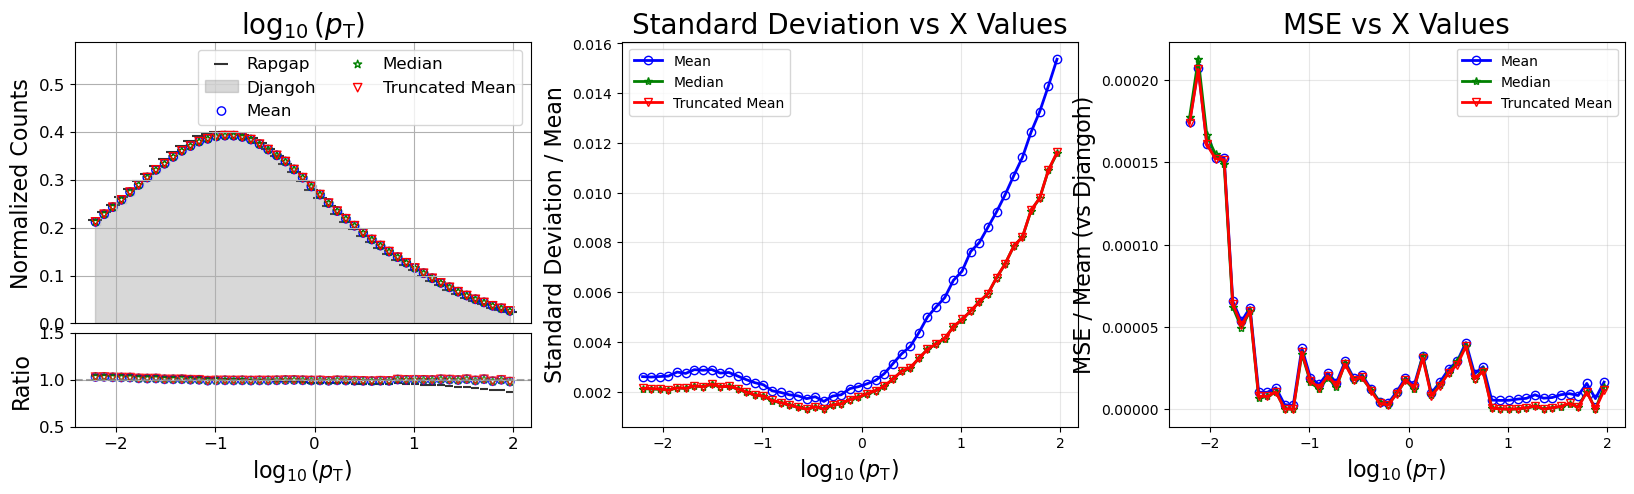

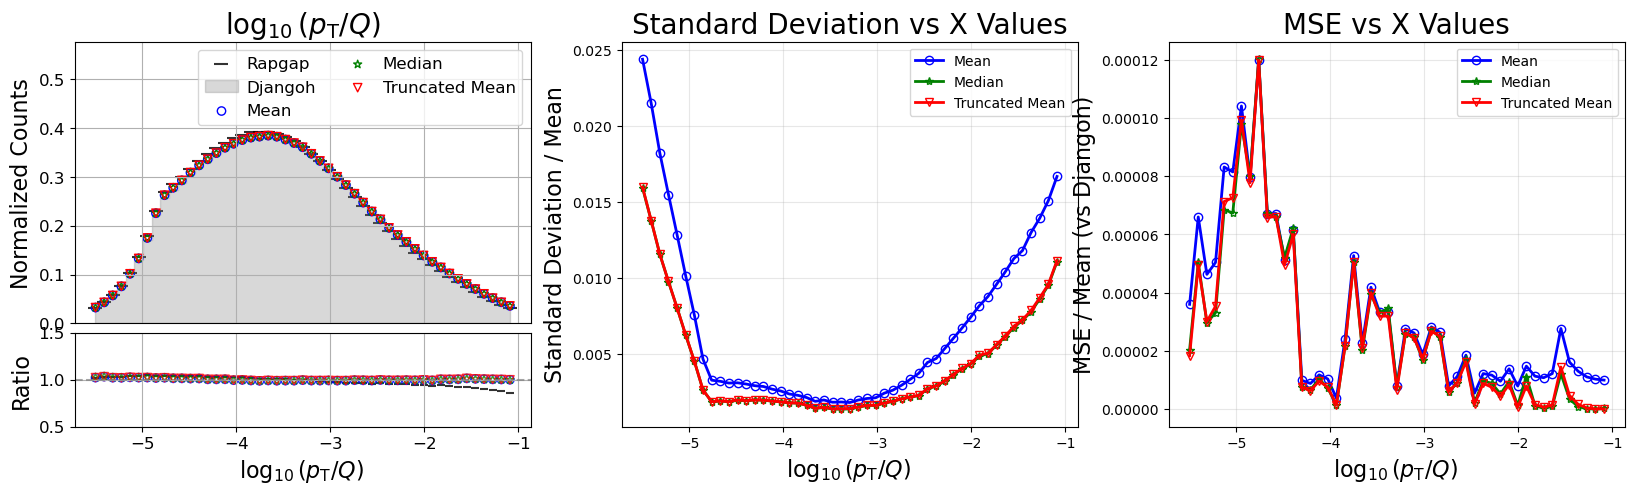

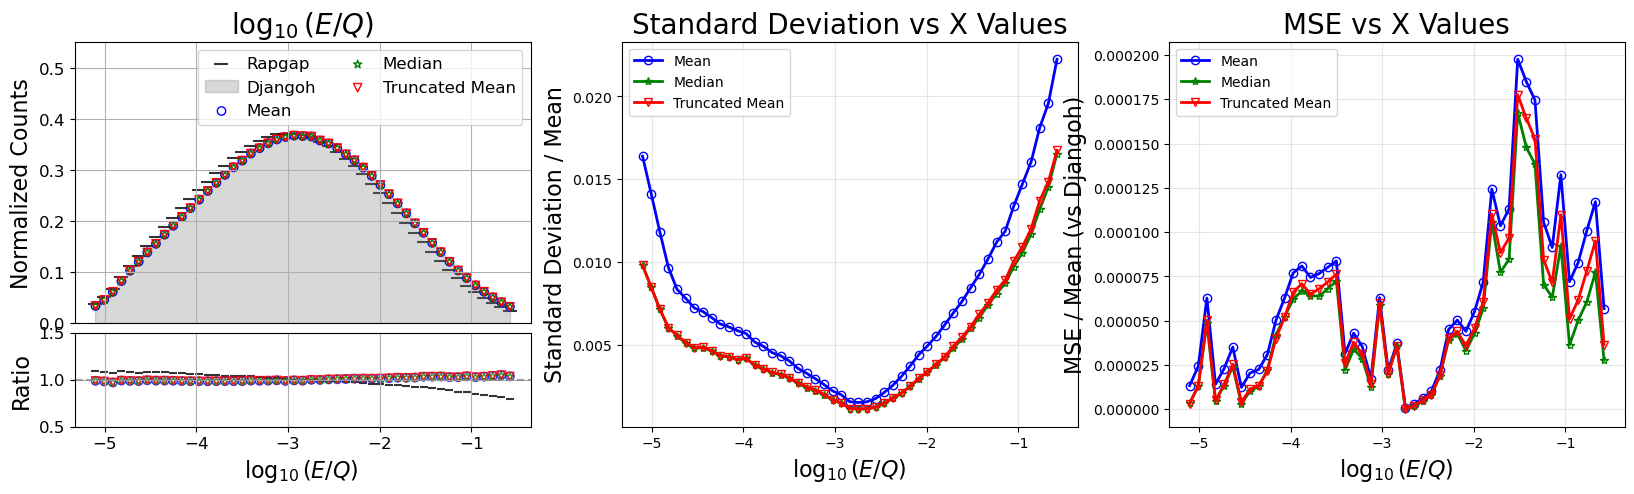

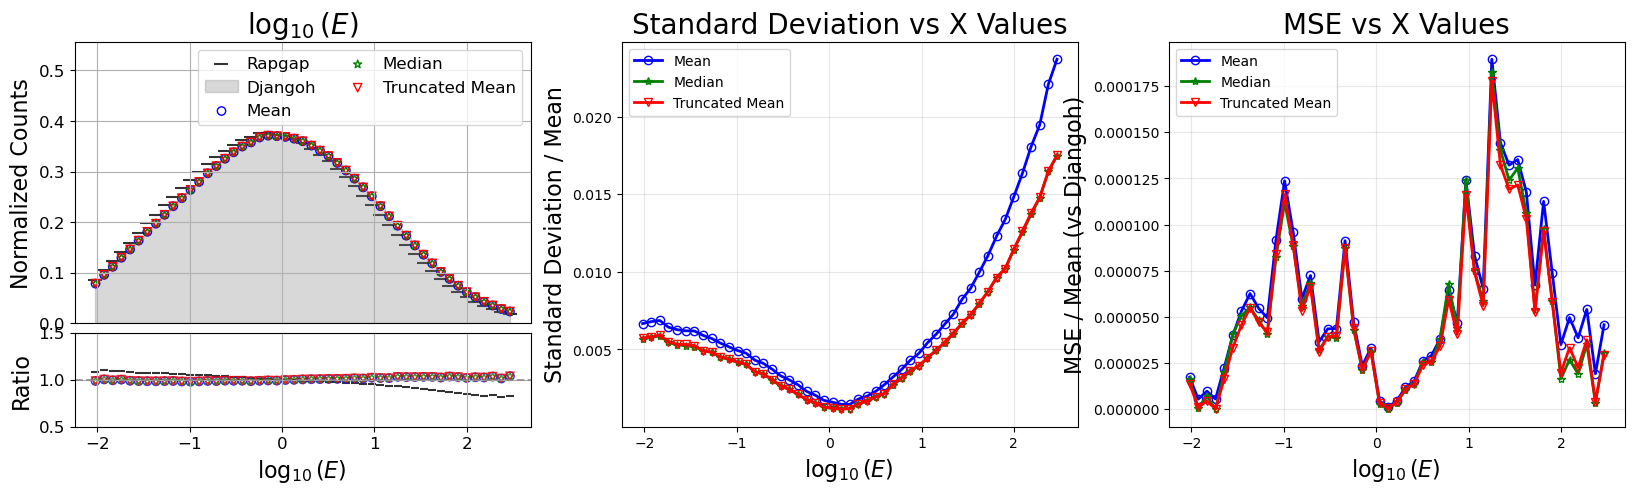

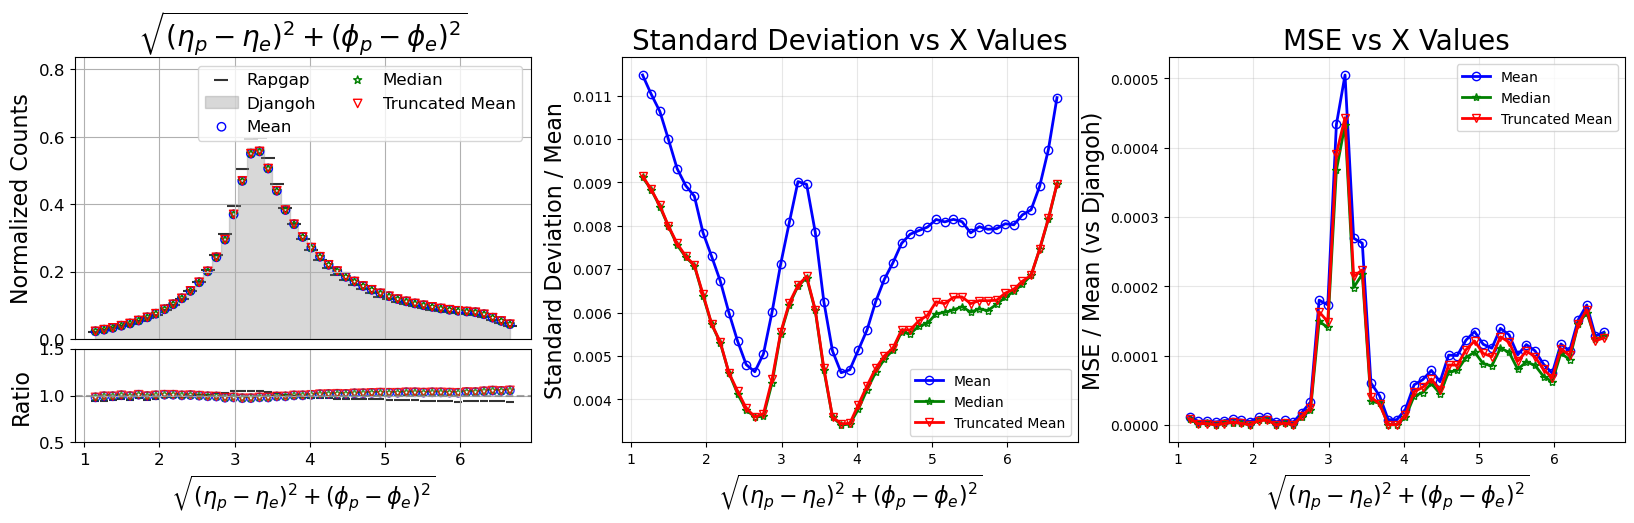

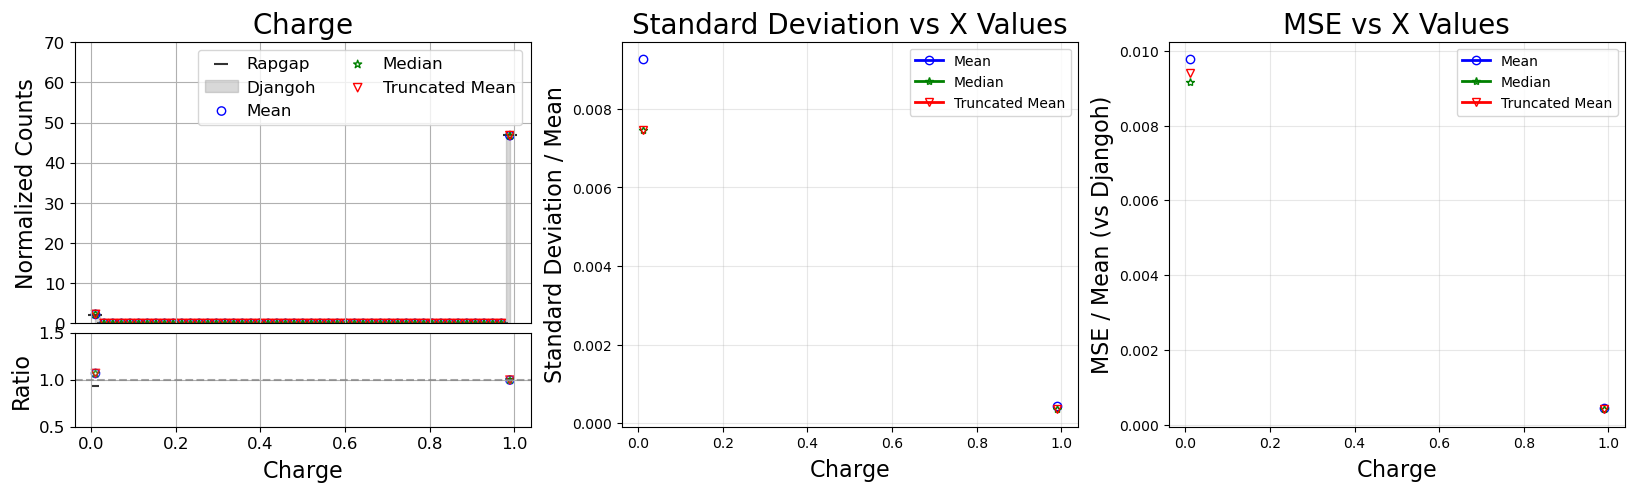

In [45]:
particle_labels = [
    '$\eta_p - \eta_e$',
    '$\phi_p-\phi_e-\pi$',
    '$\log_{10}(p_\mathrm{T})$',
    '$\log_{10}(p_\mathrm{T}/Q)$',
    '$\log_{10}(E/Q)$',
    '$\log_{10}(E)$',
    '$\sqrt{(\eta_p-\eta_e)^2+(\phi_p-\phi_e)^2}$',
    '$\mathrm{Charge}$']

particle_features = [f'particle{p}' for p in range(len(particle_labels))]

units = ["", "", "", "","", "", "", "" ]


for particle_feature, particle_label, unit in zip(particle_features, particle_labels, units):
    plot_feature(particle_feature, particle_label, particle_label, unit)
    print()